In [1]:
%load_ext autoreload

In [2]:
dataname="CUP010722MvP"
gpuid=0
patch_size=256 #size of the tiles to extract and save in the database, must be >= to training size
stride_size=256 #distance to skip between patches, 1 indicated pixel wise extraction, patch_size would result in non-overlapping tiles
mirror_pad_size=128 # number of pixels to pad *after* resize to image with by mirroring (edge's of patches tend not to be analyzed well, so padding allows them to appear more centered in the patch)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import tables
import math
from cv2 import resize
import torch
from torchvision.models import DenseNet
from torch.autograd import Variable
from torchvision import transforms
import glob

In [4]:
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11263MB, multi_processor_count=68)


In [5]:
checkpoint = torch.load(f"{dataname}_densenet_best_model.pth",  map_location=lambda storage, loc: storage) 

In [6]:

model = DenseNet(growth_rate=checkpoint["growth_rate"], block_config=checkpoint["block_config"],
                 num_init_features=checkpoint["num_init_features"], bn_size=checkpoint["bn_size"], drop_rate=checkpoint["drop_rate"], num_classes=checkpoint["num_classes"]).to(device)

print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")
model.load_state_dict(checkpoint["model_dict"])

total params: 	415554


<All keys matched successfully>

In [7]:
phase="WSI"
db=tables.open_file(f"./{dataname}_{phase}.pytable")

In [8]:
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    transforms.ToTensor()
    ])

(256, 256, 3)
(256, 256, 3)


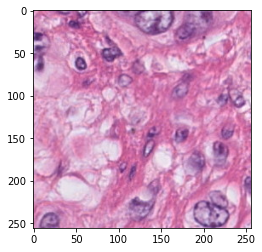

In [9]:
imgid=19

img = db.root.imgs[imgid,::]
print(img.shape)
#label = torch.tensor(db.root.labels[imgid])
label = torch.tensor(np.array(db.root.labels[imgid]))

timg=img_transform(resize(img,(patch_size,patch_size)))
print(img.shape)
plt.imshow(img)

In [10]:
len(db.root.filenames)

83365

In [11]:
testName = db.root.filenames[imgid]
testName.decode("utf-8").split('\\')[-1]

'40P (2)_85761_32513.png'

In [12]:
model.eval()

timg = timg.to(device)  # [1, 3, H, W]
print(timg.shape)
label = label.type('torch.LongTensor').to(device)  # [1] with class indices (0, 1)

output = model(timg[None,::])  
output=output.detach().squeeze().cpu().numpy() #get output and pull it to CPU
    
predlabel=np.argmax(output)
print(f"class vals: {output}")
# print(f"actual class: {label}")
print(f"predicted class: {predlabel}")

torch.Size([3, 256, 256])
class vals: [0.03914626 0.579879  ]
predicted class: 1


In [13]:
%autoreload 2
import sys
sys.path.insert(0, './pytorch-cnn-visualizations/src/')

#--- load helper function
from misc_functions import convert_to_grayscale

def rescale_grads(map,gradtype="all"):
    if(gradtype=="pos"):    #positive
        map = (np.maximum(0, map) / map.max())
    elif gradtype=="neg":
        map = (np.maximum(0, -map) / -map.min())
    else:
        map = map - map.min()
        map /= map.max()
    return map

E:\Python3\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


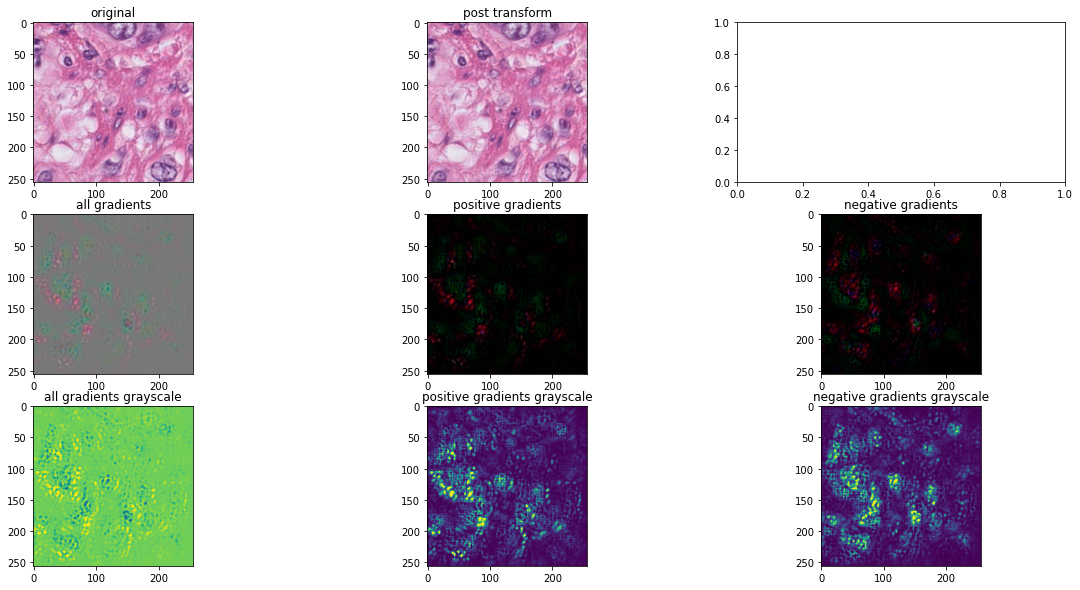

In [14]:
from vanilla_backprop import VanillaBackprop
VBP = VanillaBackprop(model,device)
vanilla_grads = VBP.generate_gradients(timg[None,::], label)
vanilla_grads=np.moveaxis(vanilla_grads,0,-1)

fig, ax = plt.subplots(3,3, figsize=(20,10))
ax = ax.flatten()

ax[0].set_title("original")
ax[0].imshow(img)

ax[1].set_title("post transform")
ax[1].imshow(np.moveaxis(timg.cpu().numpy().squeeze(),0,-1))

ax[3].set_title("all gradients")
ax[3].imshow(rescale_grads(vanilla_grads,gradtype="all"))

ax[4].set_title("positive gradients")
ax[4].imshow(rescale_grads(vanilla_grads,gradtype="pos"))

ax[5].set_title("negative gradients")
ax[5].imshow(rescale_grads(vanilla_grads,gradtype="neg"))

ax[6].set_title("all gradients grayscale")
ax[6].imshow(convert_to_grayscale(rescale_grads(vanilla_grads,gradtype="all")))

ax[7].set_title("positive gradients grayscale")
ax[7].imshow(convert_to_grayscale(rescale_grads(vanilla_grads,gradtype="pos")))

ax[8].set_title("negative gradients grayscale")
ax[8].imshow(convert_to_grayscale(rescale_grads(vanilla_grads,gradtype="neg")))

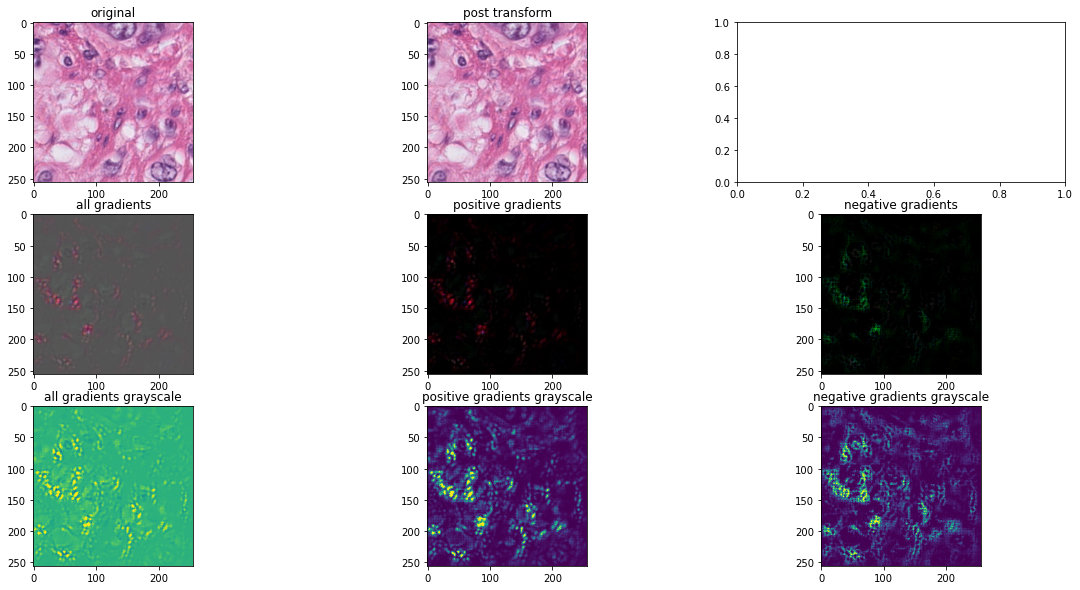

In [15]:
from guided_backprop import GuidedBackprop
GB=GuidedBackprop(model,device)
gp_grads=GB.generate_gradients(timg[None,::], label)


gp_grads=np.moveaxis(gp_grads,0,-1)

fig, ax = plt.subplots(3,3, figsize=(20,10))
ax = ax.flatten()

ax[0].set_title("original")
ax[0].imshow(img)

ax[1].set_title("post transform")
ax[1].imshow(np.moveaxis(timg.cpu().numpy().squeeze(),0,-1))

ax[3].set_title("all gradients")
ax[3].imshow(rescale_grads(gp_grads,gradtype="all"))

ax[4].set_title("positive gradients")
ax[4].imshow(rescale_grads(gp_grads,gradtype="pos"))

ax[5].set_title("negative gradients")
ax[5].imshow(rescale_grads(gp_grads,gradtype="neg"))

ax[6].set_title("all gradients grayscale")
ax[6].imshow(convert_to_grayscale(rescale_grads(gp_grads,gradtype="all")))

ax[7].set_title("positive gradients grayscale")
ax[7].imshow(convert_to_grayscale(rescale_grads(gp_grads,gradtype="pos")))

ax[8].set_title("negative gradients grayscale")
ax[8].imshow(convert_to_grayscale(rescale_grads(gp_grads,gradtype="neg")))

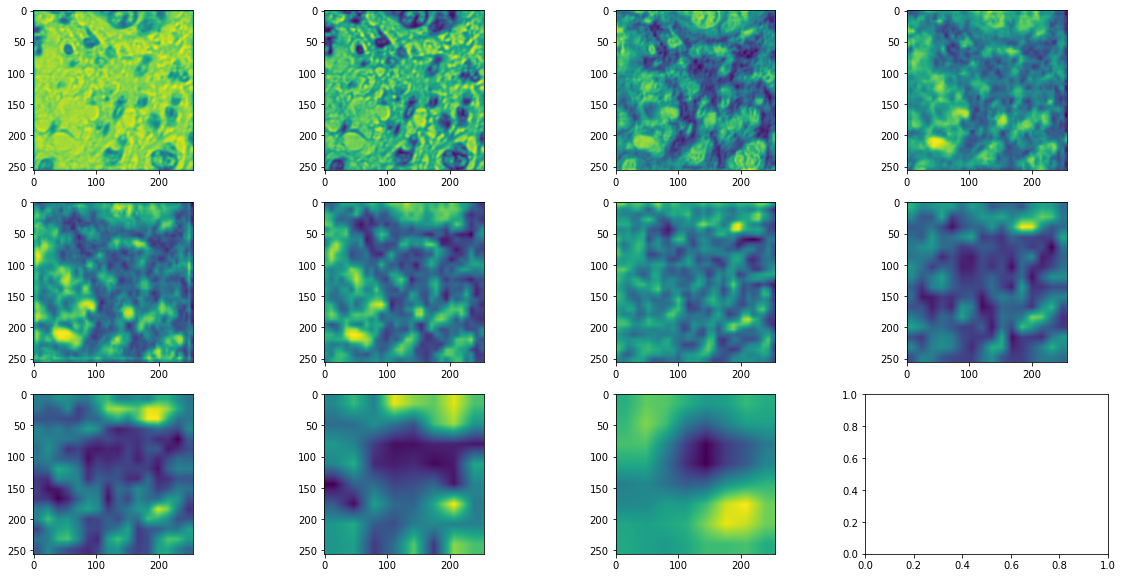

In [16]:
from gradcam import GradCam

nlayers=len(model.features._modules.items())-1

fig, ax = plt.subplots(math.ceil(nlayers/4),4, figsize=(20,10))
ax = ax.flatten()

for layer in range(nlayers):
    grad_cam = GradCam(model, device,target_layer=layer)
    cam = grad_cam.generate_cam(timg[None,::], label)
    ax[layer].imshow(cam)

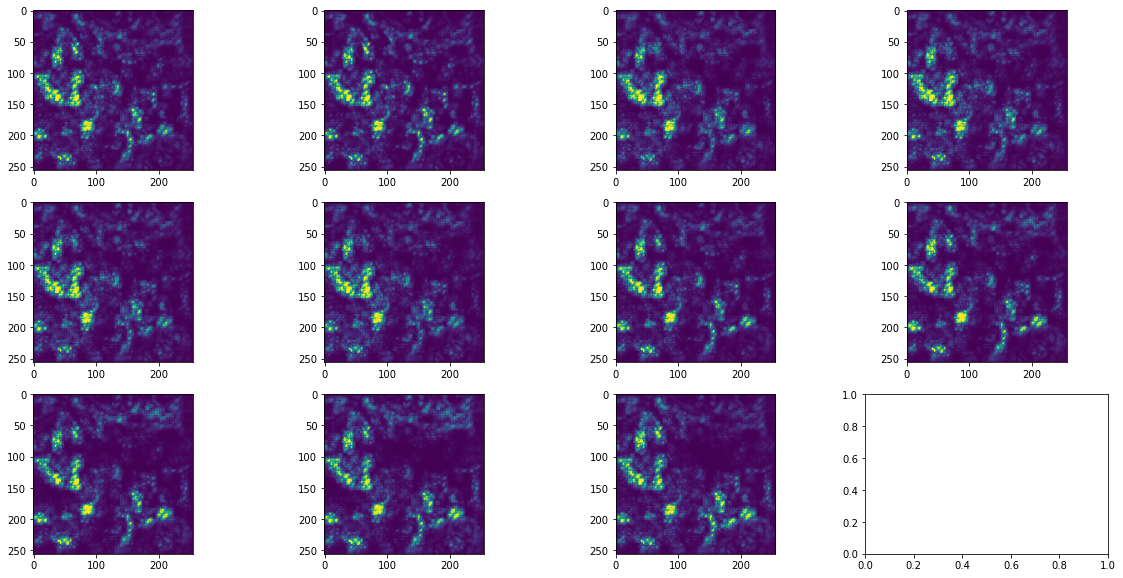

In [17]:
from gradcam import GradCam
from guided_gradcam import guided_grad_cam
from guided_backprop import GuidedBackprop

nlayers=len(model.features._modules.items())-1

fig, ax = plt.subplots(math.ceil(nlayers/4),4, figsize=(20,10))
ax = ax.flatten()

for layer in range(nlayers):
    #GradCam
    grad_cam = GradCam(model, device,target_layer=layer)
    cam = grad_cam.generate_cam(timg[None,::], label)
    #GuidedBackprop
    GBP = GuidedBackprop(model, device)
    guided_grads = GBP.generate_gradients(timg[None,::], label)
    
    # Guided Grad cam
    cam_gb = guided_grad_cam(cam, guided_grads)
    
    ax[layer].imshow(convert_to_grayscale(np.moveaxis(cam_gb,0,-1)))

In [18]:
convert_to_grayscale(np.moveaxis(cam_gb,0,-1))

array([[0.00351365, 0.00511138, 0.0111393 , ..., 0.00199178, 0.00270737,
        0.00352106],
       [0.01175615, 0.01400257, 0.01785424, ..., 0.00384403, 0.0028451 ,
        0.00352905],
       [0.01040625, 0.01268622, 0.01619807, ..., 0.004196  , 0.00219848,
        0.00339657],
       ...,
       [0.01382508, 0.02930293, 0.04000852, ..., 0.0085869 , 0.00695842,
        0.00237076],
       [0.00257966, 0.01761358, 0.01391077, ..., 0.00422946, 0.00078285,
        0.00154222],
       [0.00437165, 0.01188441, 0.0111743 , ..., 0.00208643, 0.002102  ,
        0.00239074]], dtype=float32)

In [20]:
saveMainPath = 'E:\\MvP\\FinalExperimentWithPancreas\\NewRNG\\Run3\\DeepLearningHeatmap\\GradcamMvP\\'

In [21]:
fileLoc = db.root.filenames[0]


In [22]:


label = torch.tensor(np.array(db.root.labels[0]))
label

tensor(0, dtype=torch.uint8)

In [23]:
label != predlabel

tensor(True)

In [91]:
from tqdm.notebook import tqdm_notebook
import os
for idx in tqdm_notebook(range(len(db.root.filenames))):
    fileLoc = db.root.filenames[idx]
    img = db.root.imgs[idx,::]
    label = torch.tensor(np.array(db.root.labels[idx]))
    timg=img_transform(resize(img,(patch_size,patch_size)))
    timg = timg.to(device)  # [1, 3, H, W]
    label = label.type('torch.LongTensor').to(device)  # [1] with class indices (0, 1)
    output = model(timg[None,::])  
    output=output.detach().squeeze().cpu().numpy() #get output and pull it to CPU
    predlabel=np.argmax(output)
    ff = fileLoc.decode('UTF-8').split('\\')[-2]
    fn = fileLoc.decode("utf-8").split('\\')[-1].replace('.png',f'-{label}_{predlabel}_gradCam.png')
#     if label != predlabel:
#         print(f'idx:{idx}-{label}_{predlabel}')
    grad_cam = GradCam(model, device,target_layer=nlayers)
    cam = grad_cam.generate_cam(timg[None,::], label)
    #GuidedBackprop
    GBP = GuidedBackprop(model, device)
    guided_grads = GBP.generate_gradients(timg[None,::], label)
    # Guided Grad cam
    cam_gb = guided_grad_cam(cam, guided_grads)
    if not os.path.exists(saveMainPath+f'{ff}'):
        os.mkdir(saveMainPath+f'{ff}')                
    sn = saveMainPath+f'{ff}\\{fn}'
    plt.imsave(sn, convert_to_grayscale(np.moveaxis(cam_gb,0,-1)), cmap='gray')
#     plt.imshow(convert_to_grayscale(np.moveaxis(cam_gb,0,-1)))
#     gray_img = cv2.cvtColor(convert_to_grayscale(np.moveaxis(cam_gb,0,-1)),cv2.COLOR_BGR2GRAY)
#     cv2.imwrite(sn, gray_img)

In [87]:
import os
if not os.path.exists(saveMainPath+f'{ff}'):
    os.mkdir(saveMainPath+f'{ff}')   

In [89]:
ff
fn

'12P_65537_44289-3_0_gradCam.png'

In [26]:
#MvP
label
fileLoc

b'E:\\MvP\\FinalExperimentWithPancreas\\NewRNG\\Run3\\DeepLearningHeatmap\\PvM\\WSI\\Pri\\40P (2)_85249_13057.png'

In [27]:
from tqdm.notebook import tqdm_notebook
import os
for idx in tqdm_notebook(range(len(db.root.filenames))):
    fileLoc = db.root.filenames[idx]
    img = db.root.imgs[idx,::]
    label = torch.tensor(np.array(1))# activation of Mets
    timg=img_transform(resize(img,(patch_size,patch_size)))
    timg = timg.to(device)  # [1, 3, H, W]
    label = label.type('torch.LongTensor').to(device)  # [1] with class indices (0, 1)
    output = model(timg[None,::])  
    output=output.detach().squeeze().cpu().numpy() #get output and pull it to CPU
    predlabel=np.argmax(output)
    ff = fileLoc.decode('UTF-8').split('\\')[-2]
    fn = fileLoc.decode("utf-8").split('\\')[-1].replace('.png',f'-{label}_{predlabel}_gradCam.png')
#     if label != predlabel:
#         print(f'idx:{idx}-{label}_{predlabel}')
    grad_cam = GradCam(model, device,target_layer=nlayers)
    cam = grad_cam.generate_cam(timg[None,::], label)
    #GuidedBackprop
    GBP = GuidedBackprop(model, device)
    guided_grads = GBP.generate_gradients(timg[None,::], label)
    # Guided Grad cam
    cam_gb = guided_grad_cam(cam, guided_grads)
    if not os.path.exists(saveMainPath+f'{ff}'):
        os.mkdir(saveMainPath+f'{ff}')                
    sn = saveMainPath+f'{ff}\\{fn}'
    plt.imsave(sn, convert_to_grayscale(np.moveaxis(cam_gb,0,-1)), cmap='gray')
#     plt.imshow(convert_to_grayscale(np.moveaxis(cam_gb,0,-1)))
#     gray_img = cv2.cvtColor(convert_to_grayscale(np.moveaxis(cam_gb,0,-1)),cv2.COLOR_BGR2GRAY)
#     cv2.imwrite(sn, gray_img)

NameError: name 'GradCam' is not defined